#**EfficientNet-v2**

- In last notebook we have  explain indepth about pipe line and code for the classification using EfficientNet-v1(b0), In previously written a notebook explaining all the details of the EfficientNetV1 archicture,This time we have come up with a new family of networks that have faster training speed and better parameter efficiency - EfficientNetV2! However we are using efficienetv2-s but for this exiprement we are using our own down scaled version of efficienetv2-s with the one-fouth of the parameters

In [ ]:
import os
import time
from typing import Iterable
from dataclasses import dataclass
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from torchvision import datasets, transforms
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline


#**Download Data**

This our custom dataset we have took all the images from different platforms, 

This dataset consist of 5 classes, for train and val respectively

Classes includes = (Electric_guitar, ipod, llama, microscope, owl)

In [ ]:
if not os.path.exists("data.zip"):
    !wget -qnc "https://www.dropbox.com/sh/9d0l1qry12hide5/AAAwzmjErCSUg78Yoi8Gpr9ga?dl=0" -O data.zip
!unzip -q data.zip

mapname:  conversion of  failed


#**Configurations**

In [ ]:
batch_size: int = 64
epochs_count: int = 550 
init_learning_rate: float = 0.005
test_interval: int = 1  
data_root: str = "/content" 
num_workers: int = 2  
device = torch.device("cuda")
decay_rate: float = 0.2 
log_interval = 5

In [ ]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 22 # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

In [ ]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = batch_size
    epochs_count: int = epochs_count             
    init_learning_rate: float = init_learning_rate  #0.005  # initial learning rate for lr scheduler   #TODO  0.01 is too large
    log_interval: int = log_interval  
    test_interval: int = test_interval
    data_root: str = data_root
    num_workers: int = num_workers
    device: str = device  
    decay_rate: float = decay_rate   # for lr_scheduler

#**Data Preparation**

**Prepare Data loading and augmentations**

In [ ]:
#for Image Scale 1
def image_preprocess_transforms(): 
    
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
        ])
    
    return preprocess


def image_common_transforms(mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)):
    preprocess = image_preprocess_transforms()
    
    common_transforms = transforms.Compose([
        preprocess,
        transforms.Normalize(mean, std)
    ])
    
    return common_transforms
    


def data_augmentation_preprocess():
    
    data_augmented_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20, fill=(0,0,0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees= 35),
        transforms.RandomSolarize(threshold = 120, p=0.2),
    ])
    return data_augmented_transforms




**Calcualte Mean and STD**

In [ ]:
def get_mean_std(data_root, num_workers=4):
    
    transform = image_preprocess_transforms()
    
    loader = data_loader(data_root, transform = transform, collate = None)

    mean = 0.
    std = 0.
    
    for images, _ in loader:
        batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    
    print('mean: {}, std: {}'.format(mean, std))
    
    return mean, std

**Prepare DataLoader**

You all are already familier about "get_data" function but we have change a function little bit,
now we are passing variable resolution batch of images as a input to network

In [ ]:

def get_data(batch_size, data_root, num_workers=4):
    
    train_data_path = os.path.join(data_root, 'Train')
       
    mean, std = get_mean_std(data_root=train_data_path, num_workers=num_workers)

    '''
    With the help of collate function we had manage to send 
    variable resolution batch input, we are keeping the 
    resolution in between 160 to 224,
    The collate function that we used only for train_dataloader
    for test_dataloader we are using simple image process trasfrom 
    with the input resolution of 224.
    '''

    def collate(batch):
        rand_img_size = random.randint(160, 224)

        trans = data_augmentation_preprocess()

        train_transforms = transforms.Compose([
            # Resize to rand_img_size x rand_img_size
            trans,
            transforms.Resize((rand_img_size, rand_img_size)),
            # this re-scales image tensor values between 0-1. image_tensor /= 255
            transforms.ToTensor(),
            # subtract mean (0.1307) and divide by variance (0.3081).
            # This mean and variance is calculated on training data (verify yourself)
            transforms.Normalize(mean, std)
        ])
        imgs, labels = zip(*batch)
        imgs = [train_transforms(img) for img in imgs]
        labels = [torch.tensor(label) for label in labels]
        return torch.stack(imgs), torch.stack(labels)
    
    common_transforms = image_common_transforms(mean, std)
         
    # train dataloader
    train_loader = data_loader(train_data_path,
                               collate = collate,
                               transform = None, 
                               batch_size=batch_size,
                               shuffle=True, 
                               num_workers=num_workers
                               )
    
    # test dataloader
    test_data_path = os.path.join(data_root, 'Val')
    
    test_loader = data_loader(test_data_path,
                              collate = None,
                              transform = common_transforms,  # Correction regarding Mistake 2: Originally train_transforms,       
                              batch_size=2,
                              shuffle=False, 
                              num_workers=num_workers,
                              )
    
    return train_loader, test_loader



def data_loader(data_root, collate, transform, batch_size=16, shuffle=False, num_workers=2):
    dataset = datasets.ImageFolder(root=data_root, transform=transform)
    
    loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size,
                                         collate_fn = collate,
                                         num_workers=num_workers,
                                         shuffle=shuffle)
    
    return loader

#**Training Setup**

In [ ]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

In [ ]:
device = torch.device('cuda')
criterian = nn.CrossEntropyLoss()

In [ ]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mood
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)
 
        # reset parameters gradient to zero
        optimizer.zero_grad()
        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = criterian(output, target)
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])
            
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    print('Epoch: {} \nTrain Loss: {:.6f} Acc: {:.4f}'.format(epoch_idx, epoch_loss, epoch_acc))
    return epoch_loss, epoch_acc

In [ ]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0

    true_outputs = []
    predicted_probs = []
    predicted_outputs = []

    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += criterian(output, target).item()
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        true_outputs.extend(target.cpu().tolist())
        predicted_probs.append(prob.cpu().tolist()) # append a list


        _, pred = prob.data.max(dim=1)
        # extend the output class list
        predicted_outputs.extend(pred.cpu().tolist()) 

        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    
    return test_loss, accuracy / 100.0

In [ ]:
def save_model(model, device, model_dir='models', model_file_name='brain.pt'):
    

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu.
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    torch.save(model.state_dict(), model_path)
    
    if device == 'cuda':
        model.to('cuda')
    
    return

In [ ]:
def load_model(model, model_dir='models', model_file_name='brain.pt'):
    model_path = os.path.join(model_dir, model_file_name)

    # loading the model and getting model parameters by using load_state_dict
    model.load_state_dict(torch.load(model_path))
    
    return model

In [ ]:
def main(model, optimizer, scheduler=None, system_configuration=SystemConfiguration(), 
         training_configuration=TrainingConfiguration(), data_augmentation=False):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
        print('Training using GPU')
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 4
        print('Training using CPU')

    # data loader1
    train_loader1, test_loader1 = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set
    )


    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
 
    # Calculate Initial Test Loss
 
    init_val_loss, init_val_accuracy = validate(training_configuration, model, test_loader1)
    print("Initial Test Loss : {:.6f}, \nInitial Test Accuracy : {:.3f}%\n".format(init_val_loss, 
                                                                                   init_val_accuracy*100))
    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):


       
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader1, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader1)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            ), "train_loader1"
        )

        
        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader1)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            


            if current_loss < best_loss:
                best_loss = current_loss

                print('Model Improved. Saving the Model...\n')
                save_model(model, device=training_configuration.device)


        # scheduler step/ update learning rate
        if scheduler is not None:
            #print("Learning Rate: {:.5f}".format(scheduler.get_last_lr()[0]))
            if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
                scheduler.step(train_loss)
                print("Bad Epochs:{}".format(scheduler.num_bad_epochs))
                print("last LR = {}".format(scheduler._last_lr))
            else:
                scheduler.step()
        else:
            print("Learning Rate: {:.5f}".format(optimizer.param_groups[0]['lr']))
 
        
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

In [ ]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, colors, 
                       loss_legend_loc='upper center', acc_legend_loc='upper left', 
                       fig_size=(20, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):
    
    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    
    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])
    
    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))
        
        min_train_loss = train_loss[i].min()
        
        min_val_loss = val_loss[i].min()
        
        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN LOSS ({0:.4})".format(min_train_loss))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID LOSS ({0:.4})".format(min_val_loss))
        
    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc)
    plt.title('Training and Validation Loss')
        
    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])
    
    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))
        
        max_train_acc = train_acc[i].max() 
        
        max_val_acc = val_acc[i].max() 
        
        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN ACC ({0:.4})".format(max_train_acc))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID ACC ({0:.4})".format(max_val_acc))
        
    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc)
    plt.title('Training and Validation Accuracy')
    
    fig.savefig('sample_loss_acc_plot.png')
    plt.show()
    
    return   


#**Model Setup**

There is only slight aritechtural change in the network

Depthwise convolutions are slow in early layers

We already know that the EfficientNetV1 architecture utilized MBConv layers with depthwise convolutions. Depthwise convolutions have fewer parameters and FLOPs than regular convolutions, but they often cannot fully utilize the modern accelerators. 

Recently, Fused-MBConv was proposed which replaces the depthwise 3x3 convolution and expansion 1x1 convolution in MBConv with a regular 3x3 convolution as shown in Figure below.

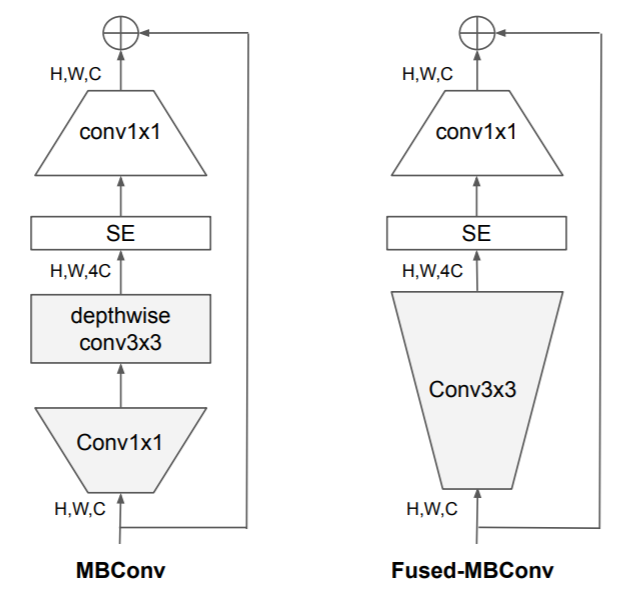

In [ ]:
import torch
import torch.nn as nn
import math

# cfgs = [
#         # t, c, n, s, SE
#         [1,  24,  2, 1, 0],
#         [4,  48,  4, 2, 0],
#         [4,  64,  4, 2, 0],
#         [4, 128,  6, 2, 1],
#         [6, 160,  9, 1, 1],
#         [6, 256, 15, 2, 1],
#     ]

cfgs = [
        # t, c, n, s, SE
        [1,  16,  1, 1, 0],
        [2,  32,  2, 2, 0],
        [2,  64,  2, 2, 0],
        [2, 128,  3, 2, 1],
        [3, 128,  3, 1, 1],
        [3, 256,  5, 2, 1],
    ]

def _make_divisible(v, divisor, min_value=None):

    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class depthwise_separable_conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(depthwise_separable_conv, self).__init__()
        self.depthwise = nn.Sequential(nn.Conv2d(in_channels,
                                                 in_channels,
                                                 kernel_size,
                                                 stride,
                                                 padding,
                                                 groups=in_channels,
                                                 bias=False,
                                                ),
                                       nn.BatchNorm2d(in_channels),
                                       nn.SiLU()
                                      )
                                       
                       
        self.pointwise = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1),
                                       nn.BatchNorm2d(out_channels),
                                       nn.SiLU()
                                      )

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out


 
class Attention(nn.Module):

    def __init__(self, inp, in_channels, reduction = 4):  #input_shape ---> output_shape
        super(Attention, self).__init__()
        
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # (c, h, w)-->(c,1,1)
            nn.Conv2d(in_channels, _make_divisible(inp // reduction, 8), 1),
            nn.SiLU(),
            nn.Conv2d(_make_divisible(inp // reduction, 8), in_channels, 1),
            nn.Sigmoid(),
        ) #Squuez_exitation layer blog

    def forward(self, x):
        return x * self.se(x)


def conv_3x3_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )


class MBConv(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio, use_se):
        super(MBConv, self).__init__()
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.identity = stride == 1 and inp == oup
        if use_se:
            self.conv = nn.Sequential(
                depthwise_separable_conv(inp, hidden_dim, 1, 1, 0),
                Attention(inp, hidden_dim),
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # fused
                depthwise_separable_conv(inp, hidden_dim, 3, stride, 1),
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )


    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


class EffNetV2(nn.Module):
    def __init__(self, num_classes):
        super(EffNetV2, self).__init__()
        self.cfgs = cfgs
        width_mult=1.0
        # building first layer
        input_channel = _make_divisible(24 * width_mult, 8)
        layers = [conv_3x3_bn(3, input_channel, 2)]
        # building inverted residual blocks
        '''
        In this function we are making the full sequental block by block by block network,
        this we are doing by using only two for loops one is accesing the data from base model,
        i.e (expand_ratio, channels, repeats, stride, kernel_size), and another is for,
        repeting the inverted resedual block and appending to the one single list wrap it
        over to Sequential API of the Pytorch
        '''
        block = MBConv
        for t, c, n, s, use_se in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 8)
            for i in range(n):
                layers.append(block(input_channel, output_channel, s if i == 0 else 1, t, use_se))
                input_channel = output_channel
                
        
        self.features = nn.Sequential(*layers)
        output_channel = 1792
        self.conv = conv_1x1_bn(input_channel, output_channel)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(output_channel, num_classes)


    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x




#**Training**

In [ ]:
model = EffNetV2(5)


train_config = TrainingConfiguration()

# logging model
optimizer = optim.Adam(
    model.parameters(),
    lr = train_config.init_learning_rate
)

factor = 0.05  
patience = 2  
threshold = 0.0001  
verbose = True     

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience=patience, verbose=verbose, threshold=threshold)
# Try cOSINE SHEDULAR

from torchsummary import summary

summary(model.to("cuda:0"), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              SiLU-3         [-1, 24, 112, 112]               0
            Conv2d-4         [-1, 24, 112, 112]             216
       BatchNorm2d-5         [-1, 24, 112, 112]              48
              SiLU-6         [-1, 24, 112, 112]               0
            Conv2d-7         [-1, 24, 112, 112]             600
       BatchNorm2d-8         [-1, 24, 112, 112]              48
              SiLU-9         [-1, 24, 112, 112]               0
depthwise_separable_conv-10         [-1, 24, 112, 112]               0
           Conv2d-11         [-1, 16, 112, 112]             384
      BatchNorm2d-12         [-1, 16, 112, 112]              32
           MBConv-13         [-1, 16, 112, 112]               0
           Conv2d-14           [

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"[INFO]: {total_params:,} total parameters. \n")


[INFO]: 3,234,701 total parameters. 



In [ ]:
model, train_loss, train_acc, val_loss, val_acc = main(model, optimizer, scheduler=None, data_augmentation=True)

Training using GPU
mean: tensor([0.5353, 0.5144, 0.4830]), std: tensor([0.2403, 0.2372, 0.2357])

Test set: Average loss: 1.6095, Accuracy: 121/599 (20%)

Initial Test Loss : 1.609468, 
Initial Test Accuracy : 20.200%

Epoch: 0 
Train Loss: 2.227080 Acc: 0.2092
Elapsed 7.06s, 7.06 s/epoch, 0.71 s/batch, ets 3877.54s train_loader1

Test set: Average loss: 1.8228, Accuracy: 121/599 (20%)

Model Improved. Saving the Model...

Learning Rate: 0.00500
Epoch: 1 
Train Loss: 1.779731 Acc: 0.2339
Elapsed 17.37s, 8.69 s/epoch, 0.87 s/batch, ets 4760.55s train_loader1

Test set: Average loss: 1.5956, Accuracy: 129/599 (22%)

Model Improved. Saving the Model...

Learning Rate: 0.00500
Epoch: 2 
Train Loss: 1.614772 Acc: 0.2639
Elapsed 27.77s, 9.26 s/epoch, 0.93 s/batch, ets 5062.68s train_loader1

Test set: Average loss: 2.4488, Accuracy: 141/599 (24%)

Learning Rate: 0.00500
Epoch: 3 
Train Loss: 1.590517 Acc: 0.2668
Elapsed 39.23s, 9.81 s/epoch, 0.98 s/batch, ets 5355.45s train_loader1

Test set

#**Loss And Accuracy Plots**

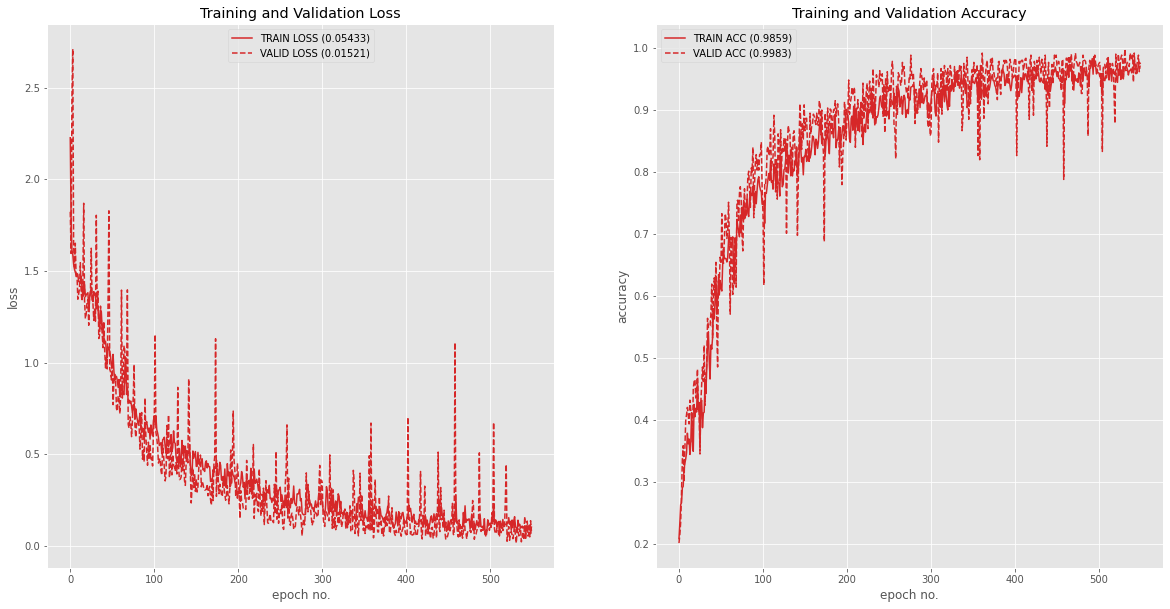

In [ ]:
plot_loss_accuracy(train_loss=[train_loss], 
                   val_loss=[val_loss], 
                   train_acc=[train_acc], 
                   val_acc=[val_acc], 
                   colors=['red'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

#**Inferance**

In [ ]:
def prediction(model, device, batch_input):
    
    # send model to cpu/cuda according to your system configuration
    model.to(device)
    
    # it is important to do model.eval() before prediction
    model.eval()

    data = batch_input.to(device)

    output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

In [ ]:
def get_sample_prediction(model, data_root, mean, std):
    batch_size = 15

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2
        
        
    
    # transformed data
    test_dataset_trans = datasets.ImageFolder(root=data_root, transform=image_common_transforms(mean, std))
    
    # original image dataset
    test_dataset = datasets.ImageFolder(root=data_root, transform=image_preprocess_transforms())
    
    data_len = test_dataset.__len__()
    
    interval = int(data_len/batch_size)
    
    imgs = []
    inputs = []
    targets = []
    for i in range(batch_size):
        index = i * interval
        trans_input, target = test_dataset_trans.__getitem__(index)
        img, _ = test_dataset.__getitem__(index)
        
        imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)
        
    inputs = torch.stack(inputs)
        
    cls, prob = prediction(model, device, batch_input=inputs)
    
    plt.style.use('default')
    plt.rcParams["figure.figsize"] = (15, 9)
    fig = plt.figure()
    
    
    for i, target in enumerate(targets):
        plt.subplot(3, 5, i+1)
        img = transforms.functional.to_pil_image(imgs[i])
        plt.imshow(img)
        plt.gca().set_title('P:{0}({1:.2}), T:{2}'.format(test_dataset.classes[cls[i]], 
                                                     prob[i], 
                                                     test_dataset.classes[targets[i]]))
    fig.savefig('sample_prediction.png')
    plt.show()
    
    return
        
    

mean: tensor([0.5353, 0.5144, 0.4830]), std: tensor([0.2403, 0.2372, 0.2357])


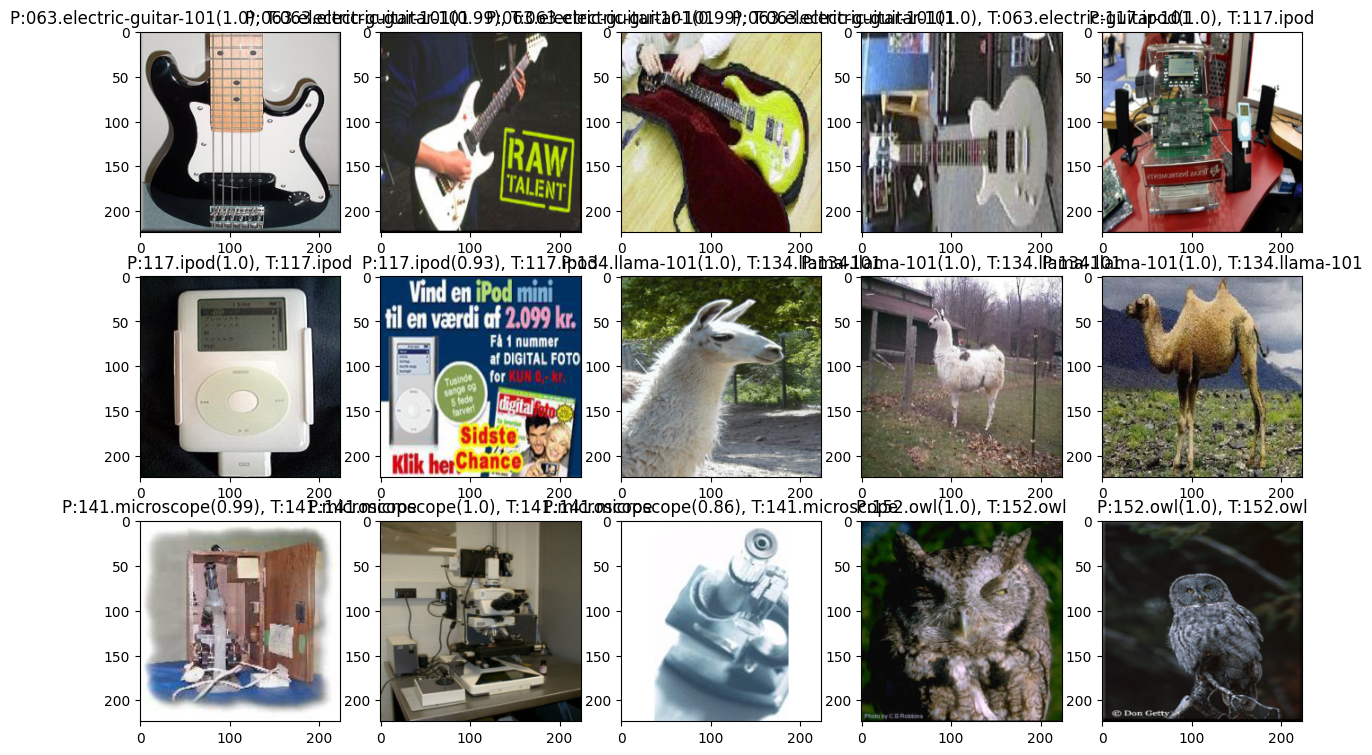

In [ ]:
m = EffNetV2(5)

m = load_model(m)

train_config = TrainingConfiguration()

test_data_path = os.path.join(train_config.data_root, 'Val')

train_data_path = os.path.join(train_config.data_root, 'Train')

mean, std = get_mean_std(train_data_path)


get_sample_prediction(m, test_data_path, mean, std)

#Latency

For comparision between Efficienet-v1 and Efficienet-v2-s, we are checking the how fast the model is on Nvidia-P100 under same condition, In privious notebook of efficinet-v1 we have seen thea time required for the model for 100 itteration is 3.22 secs , now we are doing same thing for efficenet-v2 as well

In [ ]:
def prediction(model, device, batch_input):
    
    # send model to cpu/cuda according to your system configuration
    model.to(device)
    # it is important to do model.eval() before prediction
    model.eval()
    data = batch_input.to(device)
    time1 = time.time()
    for i in range(100):
        output = model(data)
    time2 = time.time()
    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy(), time2-time1


def latency(model, data_root, mean, std):
    batch_size = 32

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2
             
    
    # transformed data
    test_dataset_trans = datasets.ImageFolder(root=data_root, transform=image_common_transforms(mean, std))
    
    # original image dataset
    test_dataset = datasets.ImageFolder(root=data_root, transform=image_preprocess_transforms())
    
    data_len = test_dataset.__len__()
    
    interval = int(data_len/batch_size)
    
    imgs = []
    inputs = []
    targets = []
    for i in range(batch_size):
        index = i * interval
        trans_input, target = test_dataset_trans.__getitem__(index)
        img, _ = test_dataset.__getitem__(index)
        
        imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)
        
    inputs = torch.stack(inputs)
    

    cls, prob, t = prediction(model, device, batch_input=inputs)
    return t

In [ ]:
latency(model = model, data_root = '/content/Train', std = 0.5, mean = 0.5)

2.331700325012207

From privios Expiriment we can conclued that, EfficientNetv1-b0 is 1.38 time slower efficientNetV2-s(down scale) on Nvidia Tesla-P100

